# As required by Minsu, get dim to 36
    next notebook I'll train Gaussian and Non-Gaussian together

# In this notebook I'm just gonna manually train 4 different models

# And use the semi_auto_encoder idea to get the compressed dv

In [1]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d

from compression_nn.preprocess_multi_piece import prepare_data_for_training
from compression_nn.compression_nn import CompressionNN
from compression_nn.utils import plot_test_error_all_param_3param

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [3]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 300
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10


In [4]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [5]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

# Process data; with ZCA whitening

In [6]:
# use only labels OMM, S8, A_IA

pars_train = pars_train[:, [0,1,3]]
pars_LFI = pars_LFI[:, [0,1,3]]



# Start Training!

In [7]:
dv_separations = [np.arange(0,160), np.arange(160,320), np.arange(320,576), np.arange(576, 608)]

In [8]:
# Base
config_list = [
    { # second moments
        'test_id': 'piece_v3_',
        'hidden_dims': [128, 64, 32, 16],
        'dropout_rate': 0.2
        },

    
    { # third moments
        'test_id': 'piece_v3_',
        'hidden_dims': [64, 32, 16],
        'dropout_rate': 0.2
        },

    
    { # Wavelet Phase Harmonics
        'test_id': 'piece_v3_',
        'hidden_dims': [128, 64, 32, 16, 8],
        'dropout_rate': 0.2
        },

    
    { # CMB lensing
        'test_id': 'piece_v3_',
        'hidden_dims': [64, 32, 16, 8],
        'dropout_rate': 0.2
        },



]

for i, piece_idx in enumerate(dv_separations):
    
    # Prepare data
    config = config_list[i]
    
    num_samples = len(pars_train)
    indices = np.random.permutation(num_samples)
    train_size = int(0.9 * num_samples)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:]


    train_loader, val_loader, test_loader, zca = prepare_data_for_training(
        train_x=dv[train_indices][:,piece_idx], #only one statistics
        train_y=pars_train[train_indices],
        val_x=dv[val_indices][:,piece_idx], #only one statistics
        val_y=pars_train[val_indices],
        test_x=dv_LFI[:,piece_idx], #only one statistics
        test_y=pars_LFI,
        batch_size=BATCH_SIZE,
        whitening = True
    )
    
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id']+'pieceIdx_'+str(i),
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act=torch.nn.ReLU(),
        arch_name = 'ResMLP'
    )

    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=20,
        loss_fun = torch.nn.L1Loss()
    )

  0%|          | 1/300 [00:02<11:30,  2.31s/it]

Epoch 1/300:
Training Loss: 0.145496
Validation Loss: 0.091681


 17%|█▋        | 51/300 [01:27<06:56,  1.67s/it]

Epoch 51/300:
Training Loss: 0.037535
Validation Loss: 0.044315


 34%|███▎      | 101/300 [02:51<05:33,  1.68s/it]

Epoch 101/300:
Training Loss: 0.036123
Validation Loss: 0.033712


 55%|█████▌    | 166/300 [04:40<03:48,  1.70s/it]

Epoch 166/300:
Training Loss: 0.0355313
Validation Loss: 0.0321675


 60%|█████▉    | 179/300 [05:03<03:25,  1.70s/it]

Early stopping triggered after 180 epochs
Best validation loss is 0.031505426520417476
Model and preprocessing saved to models/model_piece_v3_pieceIdx_0.pkl



  0%|          | 1/300 [00:01<07:14,  1.45s/it]

Epoch 1/300:
Training Loss: 0.153819
Validation Loss: 0.111111


 17%|█▋        | 51/300 [01:13<05:55,  1.43s/it]

Epoch 51/300:
Training Loss: 0.065426
Validation Loss: 0.084964


 34%|███▎      | 101/300 [02:25<04:47,  1.44s/it]

Epoch 101/300:
Training Loss: 0.063622
Validation Loss: 0.070261


 55%|█████▌    | 166/300 [03:59<03:12,  1.44s/it]

Epoch 166/300:
Training Loss: 0.0641246
Validation Loss: 0.0711243


 58%|█████▊    | 173/300 [04:10<03:03,  1.45s/it]


Early stopping triggered after 174 epochs
Best validation loss is 0.061210769517668365
Model and preprocessing saved to models/model_piece_v3_pieceIdx_1.pkl


  0%|          | 1/300 [00:01<09:19,  1.87s/it]

Epoch 1/300:
Training Loss: 0.254341
Validation Loss: 0.272350


 17%|█▋        | 51/300 [01:55<10:31,  2.54s/it]

Epoch 51/300:
Training Loss: 0.058290
Validation Loss: 0.078892


 34%|███▎      | 101/300 [03:55<08:13,  2.48s/it]

Epoch 101/300:
Training Loss: 0.056189
Validation Loss: 0.069941


 55%|█████▌    | 166/300 [05:44<03:24,  1.52s/it]

Epoch 166/300:
Training Loss: 0.0559512
Validation Loss: 0.0552953


 60%|██████    | 181/300 [06:07<02:59,  1.51s/it]

Epoch 181/300:
Training Loss: 0.0556225
Validation Loss: 0.0530073


 61%|██████    | 182/300 [06:10<03:59,  2.03s/it]


Early stopping triggered after 183 epochs
Best validation loss is 0.05190033504161341
Model and preprocessing saved to models/model_piece_v3_pieceIdx_2.pkl


  0%|          | 1/300 [00:01<06:37,  1.33s/it]

Epoch 1/300:
Training Loss: 0.144312
Validation Loss: 0.089644


 17%|█▋        | 51/300 [01:04<05:14,  1.26s/it]

Epoch 51/300:
Training Loss: 0.053918
Validation Loss: 0.081653


 34%|███▎      | 101/300 [02:07<04:13,  1.27s/it]

Epoch 101/300:
Training Loss: 0.051134
Validation Loss: 0.048458


 55%|█████▌    | 166/300 [03:31<02:50,  1.27s/it]

Epoch 166/300:
Training Loss: 0.0510388
Validation Loss: 0.0479688


 60%|██████    | 181/300 [03:51<02:37,  1.32s/it]

Epoch 181/300:
Training Loss: 0.0513306
Validation Loss: 0.0480978


 62%|██████▏   | 185/300 [03:57<02:27,  1.28s/it]

Early stopping triggered after 186 epochs
Best validation loss is 0.04796878646673827
Model and preprocessing saved to models/model_piece_v3_pieceIdx_3.pkl


# Validate seperately

/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.035
 $R^2$ = 0.976
Error S_8 = 8.912
test 0
test 1
test 2


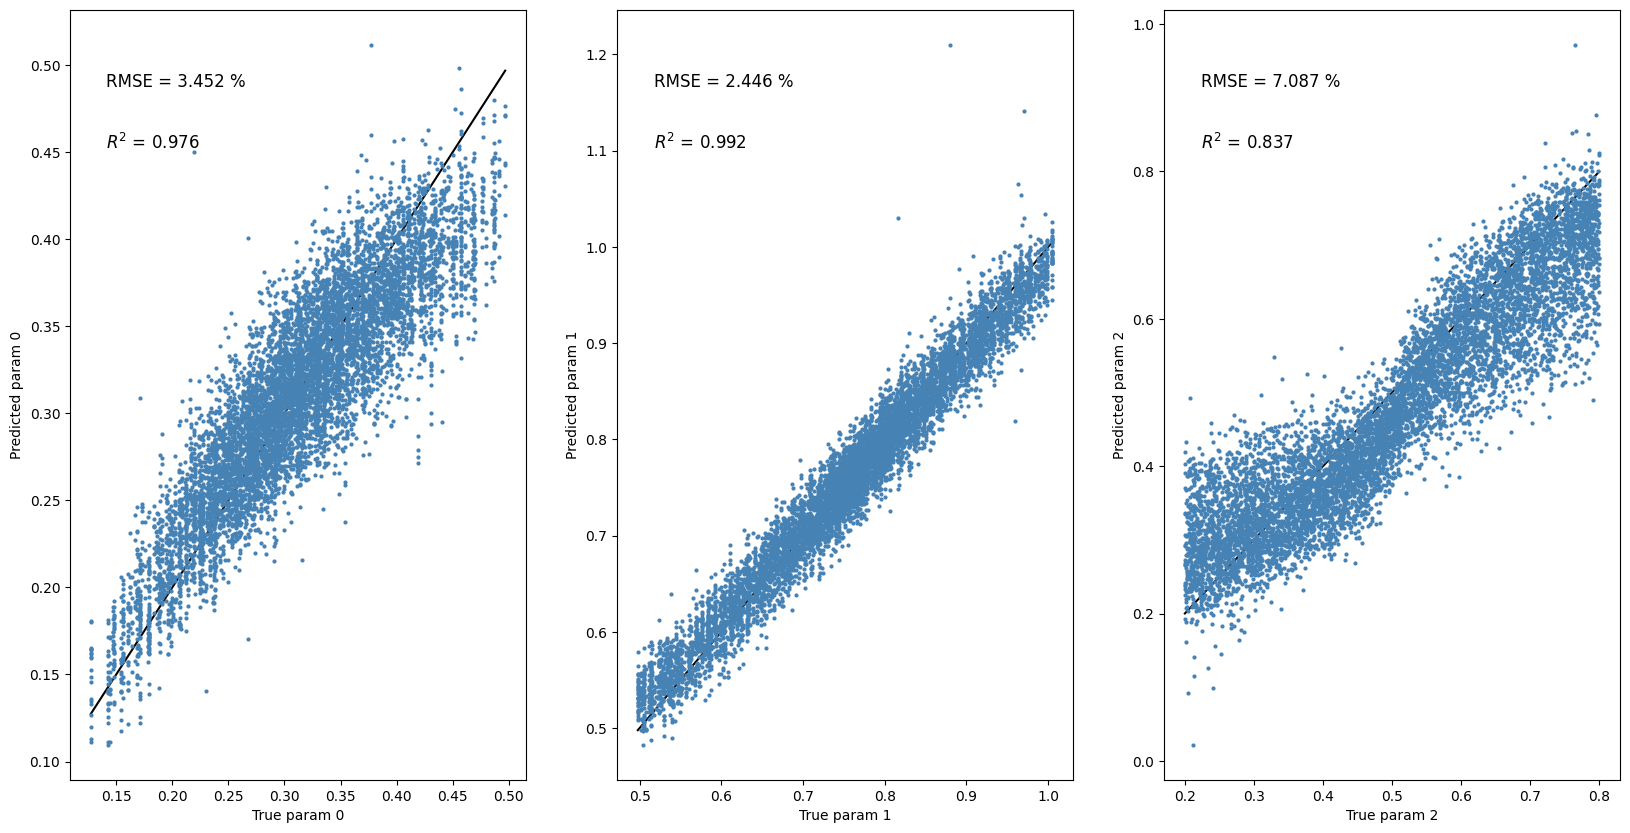

In [8]:
loaded_model = CompressionNN.load('piece_v3_pieceIdx_0')
loaded_model.model.to('cpu')

piece_idx = dv_separations[0]

num_samples = len(pars_train)
indices = np.random.permutation(num_samples)
train_size = int(0.9 * num_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[train_indices][:,piece_idx], #only one statistics
    train_y=pars_train[train_indices],
    val_x=dv[val_indices][:,piece_idx], #only one statistics
    val_y=pars_train[val_indices],
    test_x=dv_LFI[:,piece_idx], #only one statistics
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

plot_test_error_all_param_3param(loaded_model, test_loader, 3, device='cpu', output=True)


/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.070
 $R^2$ = 0.904
Error S_8 = 20.264
test 0
test 1
test 2


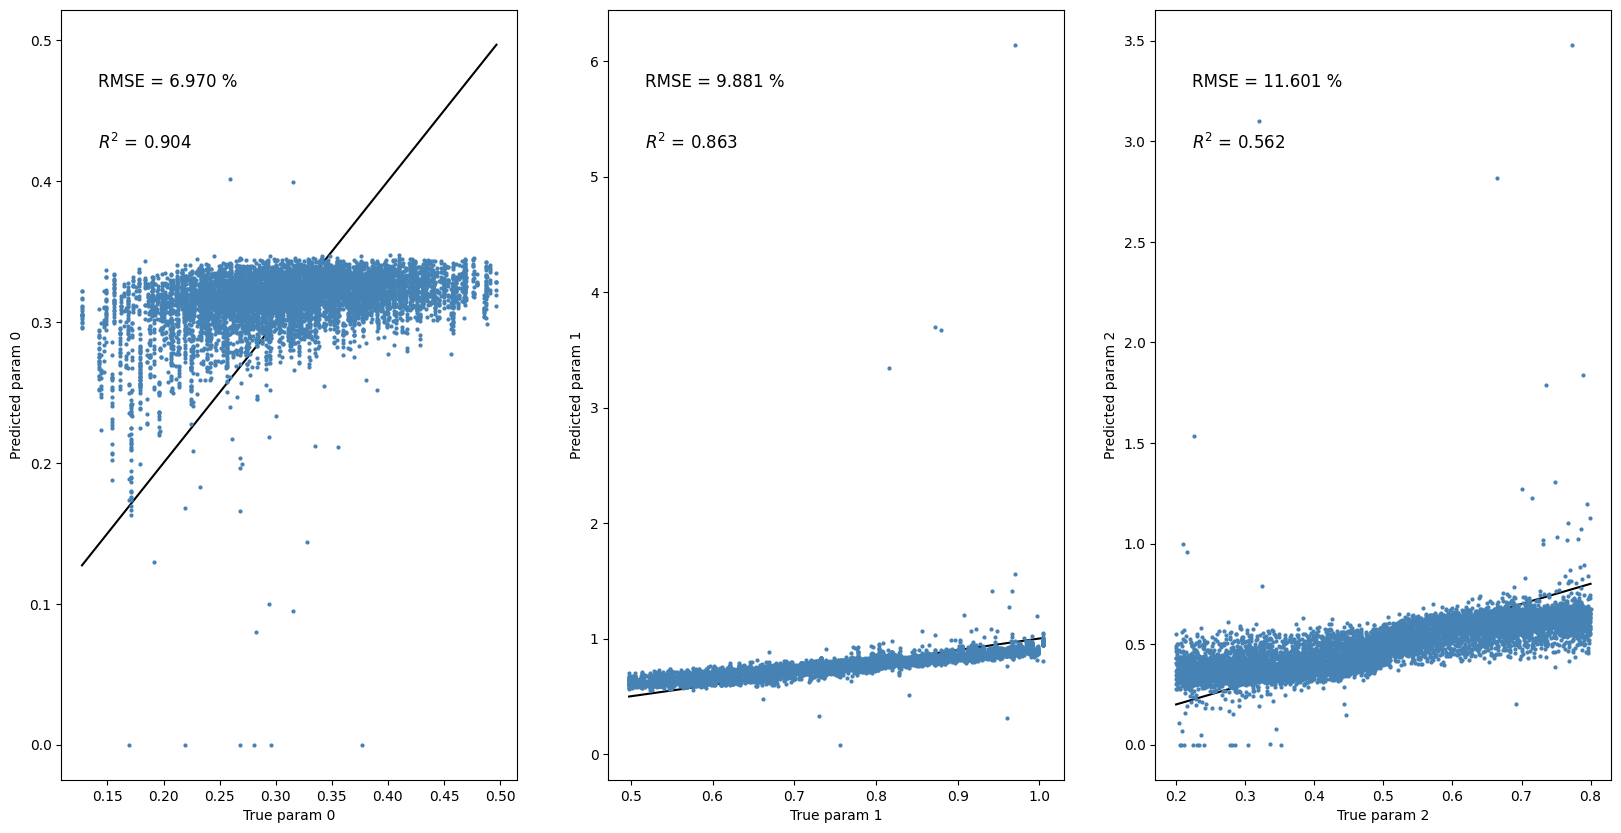

In [9]:
loaded_model = CompressionNN.load('piece_v3_pieceIdx_1')
loaded_model.model.to('cpu')

piece_idx = dv_separations[1]

# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[train_indices][:,piece_idx], #only one statistics
    train_y=pars_train[train_indices],
    val_x=dv[val_indices][:,piece_idx], #only one statistics
    val_y=pars_train[val_indices],
    test_x=dv_LFI[:,piece_idx], #only one statistics
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

plot_test_error_all_param_3param(loaded_model, test_loader, 3, device='cpu', output=True)


/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.067
 $R^2$ = 0.912
Error S_8 = 19.213
test 0
test 1
test 2


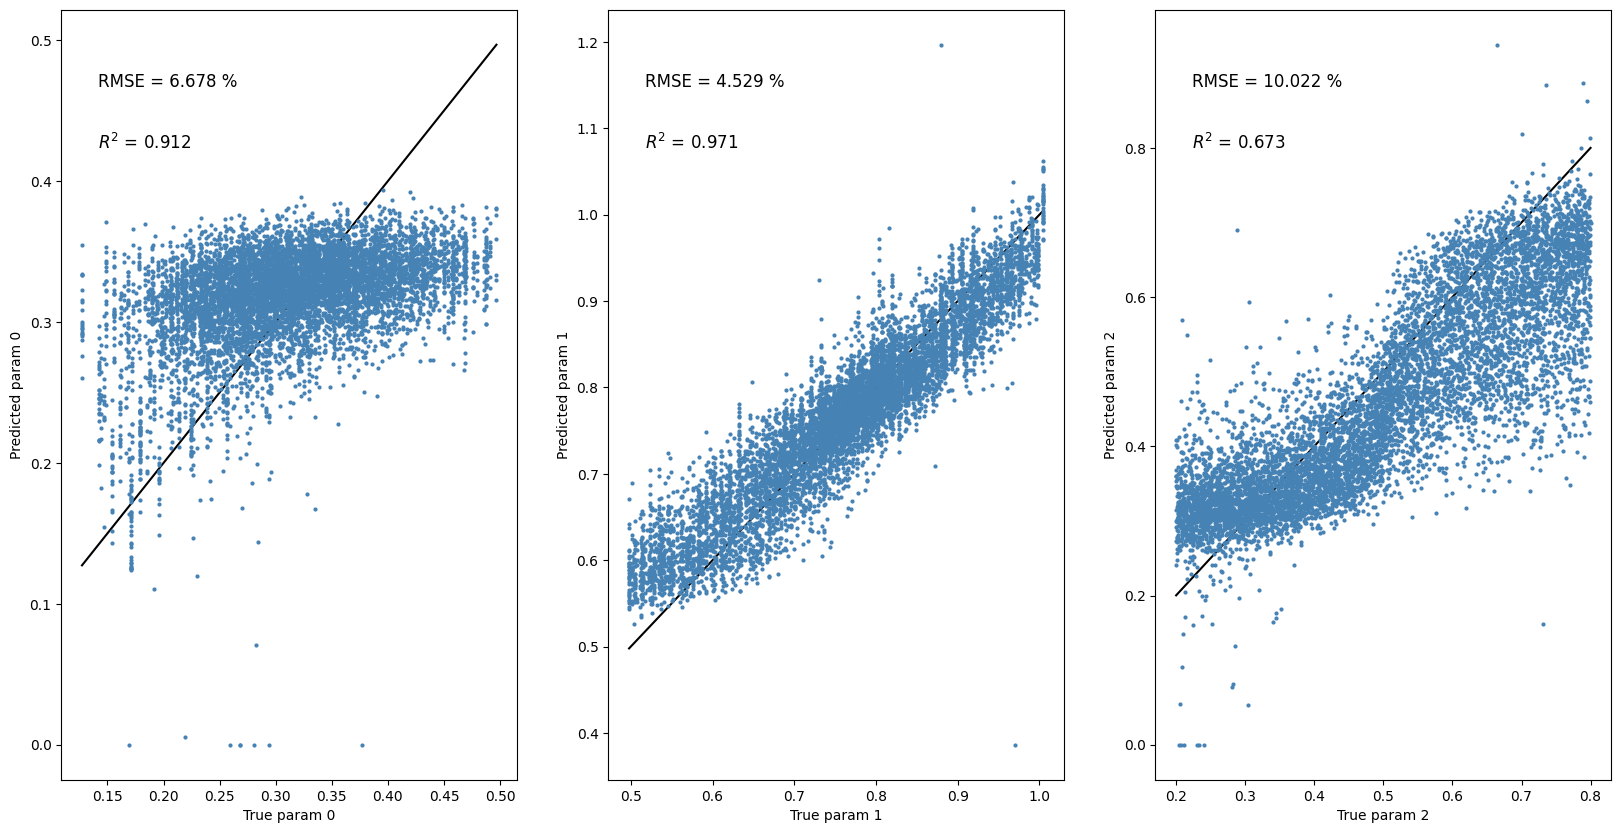

In [10]:
loaded_model = CompressionNN.load('piece_v3_pieceIdx_2')
loaded_model.model.to('cpu')

piece_idx = dv_separations[2]

# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[train_indices][:,piece_idx], #only one statistics
    train_y=pars_train[train_indices],
    val_x=dv[val_indices][:,piece_idx], #only one statistics
    val_y=pars_train[val_indices],
    test_x=dv_LFI[:,piece_idx], #only one statistics
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

plot_test_error_all_param_3param(loaded_model, test_loader, 3, device='cpu', output=True)


/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.054
 $R^2$ = 0.943
Error S_8 = 13.703
test 0
test 1
test 2


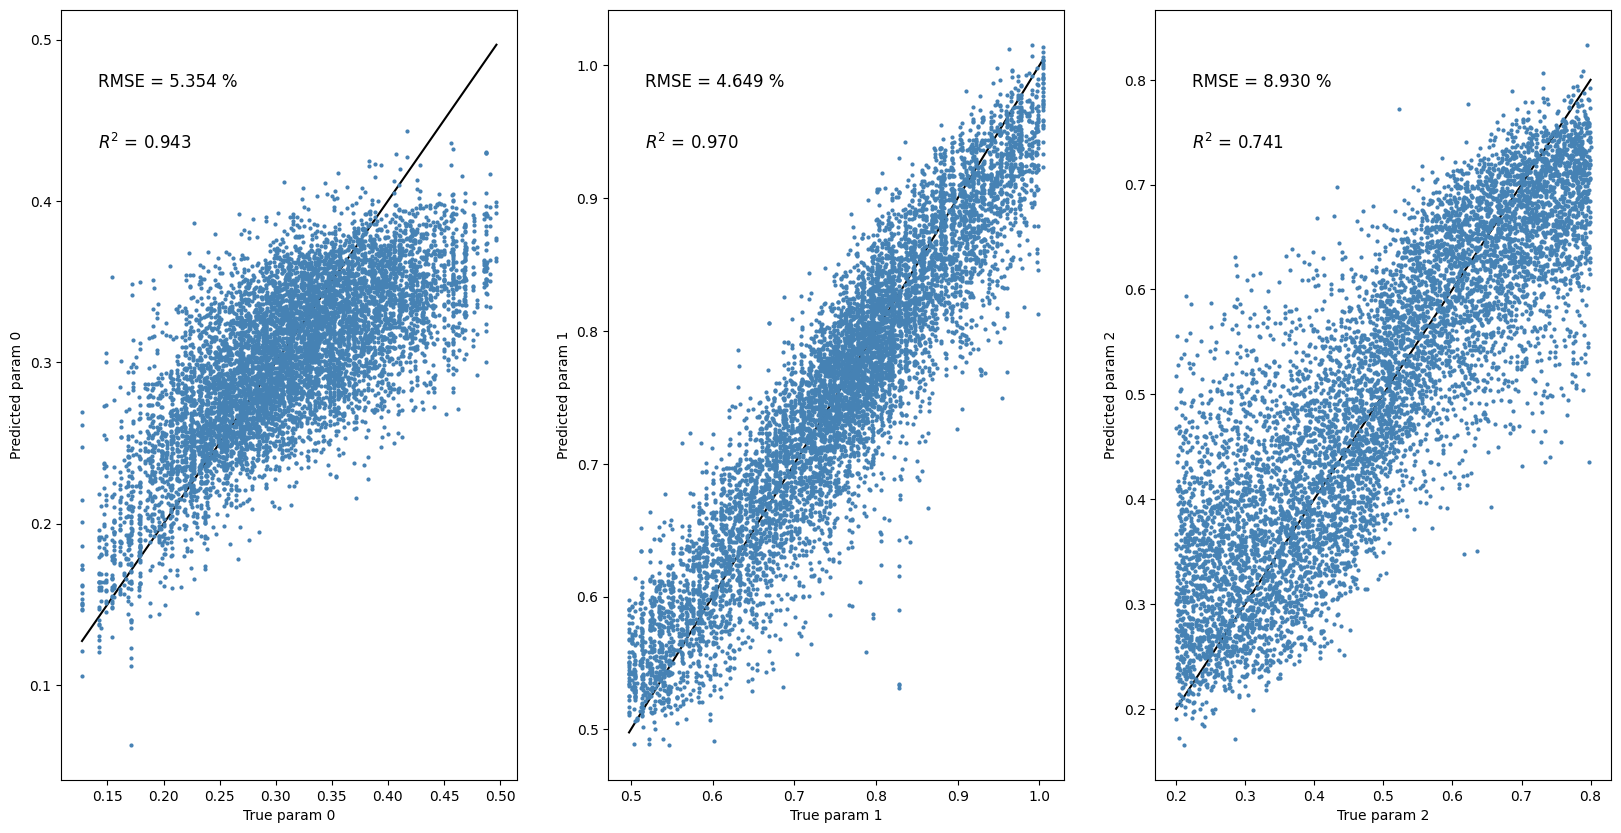

In [11]:
loaded_model = CompressionNN.load('piece_v3_pieceIdx_3')
loaded_model.model.to('cpu')

piece_idx = dv_separations[3]

# Prepare data
train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[train_indices][:,piece_idx], #only one statistics
    train_y=pars_train[train_indices],
    val_x=dv[val_indices][:,piece_idx], #only one statistics
    val_y=pars_train[val_indices],
    test_x=dv_LFI[:,piece_idx], #only one statistics
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening = True
)

plot_test_error_all_param_3param(loaded_model, test_loader, 3, device='cpu', output=True)


# Concatenate each latent space to a full compressed dv (excluding third moments cuz it's not constraining)

In [12]:
compressed_dv_semi_ae = np.zeros((dv_LFI.shape[0], 32))

for i, summary_idx in enumerate([0,2,3]):
    loaded_model = CompressionNN.load('piece_v3_pieceIdx_'+str(summary_idx))
    loaded_model.model.to('cpu')

    piece_idx = dv_separations[summary_idx]
    this_chunk_dv = dv_LFI[:,piece_idx]

    tmp = loaded_model.get_last_hidden_layer(this_chunk_dv)
    if i==0:
        print('test', i, summary_idx)
        compressed_dv_semi_ae[:,0:16] = tmp
    elif i==1:
        print('test', i, summary_idx)
        compressed_dv_semi_ae[:,16:24] = tmp
    elif i==2:
        compressed_dv_semi_ae[:,24:32] = tmp

/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

test 0 0
test 1 2


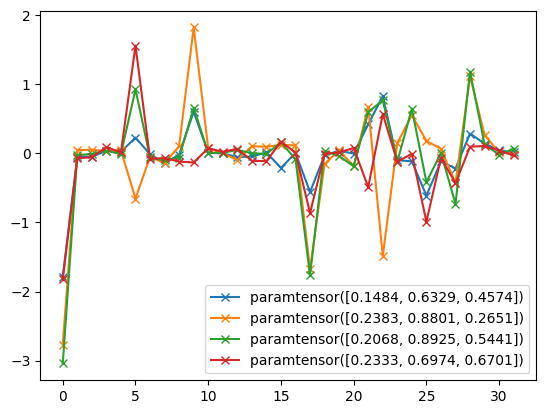

In [13]:
for i in [1,5,200,100]:
    plt.plot(compressed_dv_semi_ae[i], 'x-', label='param'+str(test_loader.dataset.tensors[1][i]))
plt.legend()

# Test at fiducial cosmology

In [ ]:
derivatives_dict = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/MOPED_derivatives.npy',allow_pickle=True).item()

dv_set_fid = derivatives_dict['WL_23_WPH_WCMBL_CMBL']['cov'][:,indict2['WL_23_WPH_short_CMBWL'] ]


In [ ]:
dv_compressed_fid_ae = np.zeros((dv_set_fid.shape[0], 32))

for i, summary_idx in enumerate([0,2,3]):
    loaded_model = CompressionNN.load('piece_v3_pieceIdx_'+str(summary_idx))
    loaded_model.model.to('cpu')

    piece_idx = dv_separations[summary_idx]
    this_chunk_dv = dv_set_fid[:,piece_idx]

    tmp = loaded_model.get_last_hidden_layer(this_chunk_dv)
    if i==0:
        print('test', i, summary_idx)
        dv_compressed_fid_ae[:,0:16] = tmp
    elif i==1:
        print('test', i, summary_idx)
        dv_compressed_fid_ae[:,16:24] = tmp
    elif i==2:
        dv_compressed_fid_ae[:,24:32] = tmp
    
dv_compressed_fid_ae = np.mean(dv_compressed_fid_ae, axis=0)

In [ ]:
compressed_dv_semi_ae.shape, dv_compressed_fid_ae.shape

In [ ]:
np.save('./output/sim_compressed_dv_piecewise_v3', compressed_dv_semi_ae)
np.save('./output/fid_compressed_dv_piecewise_v3', dv_compressed_fid_ae)